In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pickle
import pandas as pd
from IPython.display import HTML
import matplotlib.animation as animation
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
import subprocess
from time import time
import matplotlib.tri as tri
from copy import deepcopy

In [2]:
plot_fig = True
save_data = True
tstop = 0.3
dt = 5e-3
nt = int(tstop / dt + 1)
t = np.linspace(0, tstop, nt)
x0 = 0.5

# parameters
p1_arr = np.array([4])  # width of initial condition
p2_arr = np.array([1]) # height of initial condition

# p1_arr = np.array([0.6, 1.0])
# p2_arr = np.array([0.8, 1.2])

# p1_arr = np.linspace(0.6, 1.0, 18)
# p2_arr = np.linspace(0.8, 1.2, 18)

# p1_arr = np.linspace(4, 4.3, 2)
# p2_arr = np.linspace(1, 1.4, 2)


params = {}
params['pde'] = {}
params['pde']['exe_file'] = '../../../src/ex16'
params['pde']['m_file'] = '../../../src/ref-square.mesh'
params['pde']['u_file'] = '../temp/ex16-u_pred.gf'
params['pde']['res_file'] = "../temp/ex16-residual.gf"
params['pde']['rl'] = 5
params['pde']['order'] = 1
params['pde']['ODEsolver'] = 1 # 1 - Backward Euler, 2 - SDIRK2, 3 - SDIRK3
params['pde']['tstop'] = tstop
params['pde']['dt'] = dt
params['pde']['x1'] = x0
params['pde']['x2'] = x0
params['pde']['res_ns'] = 0.2 # percentage of time steps for residual evaluation
params['pde']['Tmax_iter'] = 30 # max number of CG iterations in Tsolver

In [3]:
## Compact Finite Difference Method ###
def D_Lele(N,h):
    d=[-1, 0, 1];
    B1=3/8*np.ones(N)
    B2=3/8*np.ones(N)
    B1[-2]=3
    B1[-3]=1/4
    B1[-4]=1/3
    B1[0]=1/4
    B1[1]=1/3
    B2[1]=3
    B2[2]=1/4
    B2[3]=1/3
    B2[-1]=1/4
    B2[-2]=1/3
    A=spdiags([B1, np.ones(N), B2],d, N,N)
    
    alf=25/32/h
    bet=1/20/h
    gam=-1/480/h
    d=np.arange(-3,4)
    
    # d=-3
    B1=-gam*np.ones(N)
    B1[-4]=1/6/h
    B1[-5]=0
    B1[-6]=0
    # d=-2
    B2=-bet*np.ones(N)
    B2[0]=-1/36/h
    B2[-3]=-3/2/h
    B2[-4]=0
    B2[-5]=-1/36/h
    # d = -1
    B3=-alf*np.ones(N)
    B3[0]=-3/4/h
    B3[1]=-7/9/h
    B3[-2]=-3/2/h
    B3[-3]=-3/4/h
    B3[-4]=-7/9/h
    # d = 0
    B4=np.zeros(N)
    B4[0]=-17/6/h
    B4[-1]=17/6/h
    # d = 1
    B5=alf*np.ones(N)
    B5[1]=3/2/h
    B5[2]=3/4/h
    B5[3]=7/9/h
    B5[-1]=3/4/h
    B5[-2]=7/9/h
    # d = 2
    B6=bet*np.ones(N)
    B6[2]=3/2/h
    B6[3]=0
    B6[4]=1/36/h
    B6[-1]=1/36/h
    # d = 3
    B7=gam*np.ones(N)
    B7[3]=-1/6/h
    B7[4]=0
    B7[5]=0
    B=spdiags([B1, B2, B3, B4, B5, B6, B7],d,N,N)
    return spsolve(A.tocsc(),B.tocsc()) 

def derivative(X):
    dXdt = np.empty(X.shape)
    D = D_Lele(X.shape[0], tstop/(X.shape[0]-1))   
    for i in range(X.shape[1]):
        dXdt[:,i] = np.dot(D.toarray(), X[:,i])
    del D
    return dXdt

def plot_u(u, du):
    vmin_x = u.min()
    vmax_x = u.max()
    vmin_dx = du.min()/4
    vmax_dx = du.max()/4
    
    fig = plt.figure(figsize=(18,3))
    ax = fig.add_subplot(151)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - time: {0}')
    tpc = ax.tripcolor(triang, u[0], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(152)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - time: {5}')
    tpc = ax.tripcolor(triang, u[5], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(153)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - time: {0}')
    tpc = ax.tripcolor(triang, du[0], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(154)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - time: {5}')
    tpc = ax.tripcolor(triang, du[5], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(155)
    ax.plot(t, u.mean(axis=1))
    ax.set_xlabel('time (s)', fontsize=12)
    ax.set_ylabel('mean temperature', fontsize=12)
    ax.set_xlim(0, tstop)
    ax.tick_params(labelsize=12)
    plt.grid()
    
    plt.tight_layout()
#     plt.savefig('./fig/u_vs_time_2d.png')
    plt.show()

case 1 - width: 4, height: 1
1.0587276535911627e-05 1.9999896450546142 -56.40967573974946 90.93449495500701


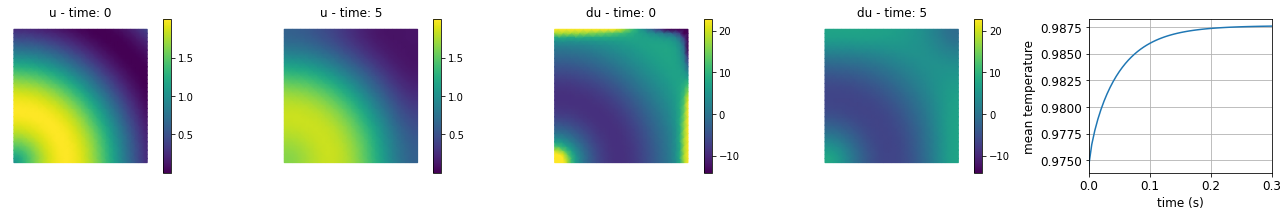

average time for computing x: 6.70 s
(61, 1089) (61, 1089)


In [27]:
# generate training set
data = []
param = []
total_time = 0
case_id = 1
for i in p1_arr:
    for j in p2_arr:
        snapshot = {}
        param.append(np.array([i, j]))
        params['pde']['width'] = i
        params['pde']['height'] = j
#         params['pde']['x1'] = j
#         params['pde']['x2'] = j
#         print(f'case {case_id} - width: {i}, x: {j}')
        print(f'case {case_id} - width: {i}, height: {j}')
        
        # compute u and du
        time0 = time()
        subprocess.call([params['pde']['exe_file'],
                         '-m', params['pde']['m_file'],
                         '-uf', params['pde']['u_file'],
                         '-rf', params['pde']['res_file'],
                         '-r', str(params['pde']['rl']),
                         '-o', str(params['pde']['order']),
                         '-s', str(params['pde']['ODEsolver']),
                         '-tf', str(params['pde']['tstop']),
                         '-dt', str(params['pde']['dt']),
                         '-h0', str(params['pde']['height']),
                         '-w0', str(params['pde']['width']),
                         '-x1', str(params['pde']['x1']),
                         '-x2', str(params['pde']['x2']),
                         '-no-vis',
                         '-no-visit',])
        time1 = time()
        t_fom = time1 - time0
        total_time += t_fom
        
        # collect data
        snapshot = {}
        u_all = []
        du_all = []
        for k in range(int(nt)):
            u = np.loadtxt(f'./ex16-u_{k:d}.gf', skiprows=5, dtype='float')
            u_all.append(u)
            
        u_all = np.vstack(u_all)
        du_all = derivative(u_all)
    
        # Normalize u and du to [0,1], MinMaxScaler transforms features by scaling each feature to a given range.
#         u2 = deepcopy(u_all)
#         du2 = deepcopy(du_all)
#         u_min = u_all.min()
#         u_all -= u_min
#         u_max = u_all.max()
#         u_all /= u_max
        
#         du_min = du_all.min()
#         du_all -= du_min
#         du_max = du_all.max()
#         du_all /= du_max
        
        snapshot['x'] = u_all
        snapshot['dx'] = du_all
        snapshot['t'] = np.linspace(0,tstop,u_all.shape[0])
        snapshot['time_fom'] = t_fom
#         snapshot['u_min'] = u_min
#         snapshot['u_max'] = u_max
#         snapshot['du_min'] = du_min
#         snapshot['du_max'] = du_max
        print(u_all.min(), u_all.max(), du_all.min(), du_all.max())
        data.append(snapshot)
        
        # triangulation for plotting
        # vertex.txt contains nodal coordinates
        if case_id == 1:
            mesh = pd.read_csv('ex16.mesh')
            idx = mesh[mesh.iloc[:,0].str.startswith('vertices')].index[0]
            vert = mesh.iloc[idx+3:,:] # nodal coordinates
            vert.to_csv('../data/vertex.txt', index=False, header=False)
            vert = np.array([x.split(' ') for x in vert.to_numpy()[:,0]], dtype=float)
            triang = tri.Triangulation(vert[:,0], vert[:,1])
            
        if plot_fig:
            plot_u(u_all, du_all)
        case_id += 1
        
data_all = {}
data_all['data'] = data
data_all['param'] = param
print(f"average time for computing x: {total_time/len(data_all['data']):.2f} s")
print(snapshot['x'].shape, snapshot['dx'].shape) 

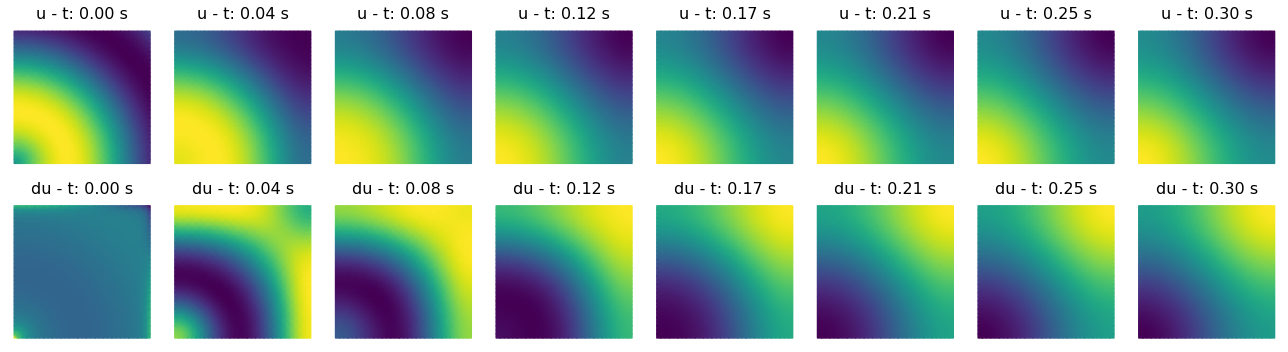

In [21]:
nplot = 8
step_list = np.linspace(0,nt-1,nplot,dtype=int)

fig = plt.figure(figsize=(18,5))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, u_all[step], shading='gouraud')
    ax.set_title(f'u - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1+nplot)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, du_all[step], shading='gouraud')
    ax.set_title(f'du - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('./ex16_multisteps.png')

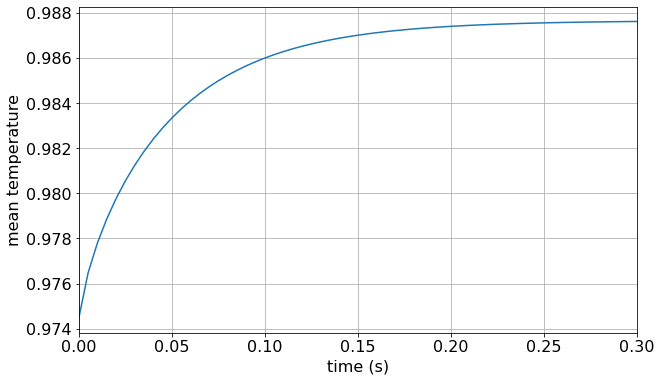

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(t, u_all.mean(axis=1))
ax.set_xlabel('time (s)', fontsize=16)
ax.set_ylabel('mean temperature', fontsize=16)
ax.set_xlim(0, tstop)
ax.tick_params(labelsize=16)
plt.grid()
plt.savefig('./ex16_meanT_vs_t.png')

In [23]:
# u3 = u_all * u_max + u_min
# du3 = du_all * du_max + du_min
# np.linalg.norm(u2-u3)
# np.linalg.norm(du2-du3)

In [24]:
print(data[0]['x'].min(), data[0]['x'].max(), data[0]['dx'].min(), data[0]['dx'].max())

1.0587276535911627e-05 1.9999896450546142 -56.40967573974946 90.93449495500701


In [25]:
# t = np.linspace(0,tstop,nt)
# step_list = np.linspace(0,nt-1,10,dtype=int)
# vmin = u_all.min()
# vmax = u_all.max()

# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)
# for step in step_list:
#     ax = plt.gca()
#     tpc = ax.tripcolor(triang, u_all[step], shading='gouraud', vmin=vmin, vmax=vmax)
#     plt.axis('off')
#     plt.savefig(f'./snapshot/t{t[step]:.2f}s.png')

In [9]:
num_case = len(data)

# save data
if save_data:
    if num_case > 1:
        pickle.dump(data_all, open(f"../data/local{num_case}_tstop{tstop:.1f}c.p", "wb"))
    else:
        pickle.dump(data_all, open(f"../data/local{num_case}_p1{p1_arr[0]:.1f}_p2{p2_arr[0]:.1f}_tstop{tstop:.1f}.p", "wb"))